### LevSort 
This notebook is an implementation of the algorithm proposed in [1] on page 7. For the idea behind the matching step (II) in the LevSort algorithm consult [this post](https://stackoverflow.com/a/54041501/22817499) on stackoverflow.

[1] “Denoising linear models with permuted data” by A. Pananjady, M. Wainwright and T. A. Courtade, 2017, IEEE International Symposium on Information Theory, 446-450.

In [20]:
# some necessary imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolor
from itertools import combinations, permutations
from imageHelpers import *

In [21]:
def LevSort(denoisedY, A, returnLevScores=False):
    '''
        The LevSort algorithm from [1]
        
        IN:  denoisedY   <-> np.ndarray which fulfills Y = Pi @ A @ X, where the matrices Pi
                             and X are to be determined and A is as described below
             A           <-> np.ndarray
        
        OUT: Pihat, Xhat <-> both np.ndarray's
        
        
        [1]  “Denoising linear models with permuted data” by A. Pananjady, M. Wainwright and 
             T. A. Courtade, 2017, IEEE International Symposium on Information Theory, 446-450.
    '''
    epsilon = 1e-11
    
    ###
    ### (I) Compute leverage scores l(denoisedY) and l(A).
    ###
    
    # first, compute SVDs for the two matrices
    
    U_Y, sigmas_Y, _ = np.linalg.svd(denoisedY)
    U_A, sigmas_A, _ = np.linalg.svd(A)
    
    # only consider the reduced forms of the matrices U_Y, U_A
    kY = sum([1 if sigma > epsilon else 0 for sigma in sigmas_Y])
    kA = sum([1 if sigma > epsilon else 0 for sigma in sigmas_A])
    
    U_Y = U_Y[:, :kY]
    U_A = U_A[:, :kA]
    
    # compute the leverage scores
    lY = np.diag(U_Y @ U_Y.T)
    lA = np.diag(U_A @ U_A.T)
    
    ###
    ### (II) Find a permutation matrix Pi that minimises ||lY - Pi @ lA||
    ###
    
    n = len(lY)
    # np.argsort gives the inverse permutation that is needed to go from the unsorted
    # to the sorted array
    
    piInv_lA = np.argsort(lA) 
    piInv_lY = np.argsort(lY)
    
    # construct the inverse permutation of piInv_lA, i.e. pi_lA
    pi_lA = np.zeros(n, dtype=int)
    for i, piInv_i in enumerate(piInv_lA):
        pi_lA[piInv_i] = i
    
    # to permute the entries of lA such that the euclidean norm is minimal, apply piInv_lY 
    # composed with pi_lA to its indices
    permute_lA_to_lY = [piInv_lY[pi_lA[i]] for i in range(n)]
    
    
    # finally construct the permutation matrix Pihat
    Pihat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            Pihat[i, j] = 1 if permute_lA_to_lY[j] == i else 0
    
    
    ###
    ### (III) Compute X = pseudoInverse(Pi @ A) @ Y
    ###
    
    Xhat = np.linalg.pinv(Pihat @ A) @ denoisedY
    
    # if requested, also return the leverage scores lY and lY
    if returnLevScores:
        return Pihat, Xhat, lY, lA
    
    return Pihat, Xhat

In [22]:
def singularValueThresholding(X, lamb, returnSigmasRemoved=False):
    '''
        function that executes the SVT
    '''
    U, sigmas, Vh = np.linalg.svd(X, full_matrices=False)
    sigmaIndices = sigmas >= lamb
    sigmas = sigmas[sigmaIndices]
    U = U[:, sigmaIndices]
    Vh = Vh[sigmaIndices]
    
    if returnSigmasRemoved:
        return (U * sigmas) @ Vh, sum(sigmaIndices) < len(sigmaIndices)
    
    return (U * sigmas) @ Vh

In [23]:
def randomPermutation(rng, n):
    '''
        function that generates a random nxn permutation matrix
    '''
    indices = np.array([i for i in range(n)])
    rng.shuffle(indices)
    
    PiStar = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            PiStar[i, j] = 1 if indices[j] == i else 0

    return PiStar

### Example 1: Pose and Correspondence Estimation with known $(\Pi^*, X^*)$

- Detect key features in original image and save them in $A$
- Transform original image by $X^*$ and set $Y = \Pi^* A X^*$
- Estimate $(\hat{\Pi}, \hat{X})$ with $\texttt{LevSort}$

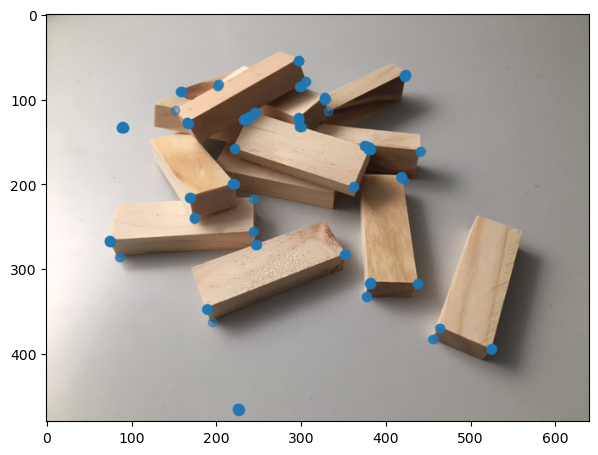

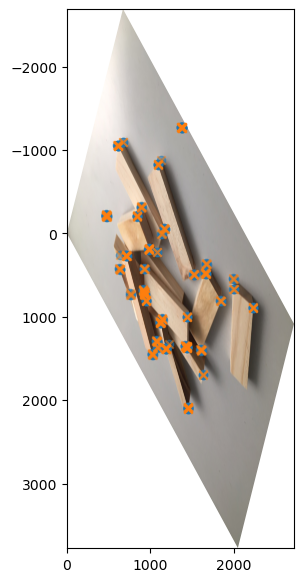

In [24]:
rng = np.random.default_rng(seed=12345)
parametersHarris = [2, 5, 0.01]
imageName = 'building_blocks.JPG'

### detect corners in the picture
A = detectCorners(imageName, parametersHarris)

### plot the detected corners
plotImage(imageName, A)

### construct the permutation matrix PiStar
n = len(A)
PiStar = randomPermutation(rng, n)

### construct the linear transformation XStar
XStar = np.array([[3.2, 5.9], [1.4, -5.6]])

Y = PiStar @ A @ XStar

Pihat, Xhat = LevSort(Y, A)
Yhat = Pihat @ A @ Xhat

plotTransformedImage(imageName, XStar, Yhat, Y)

### Example 2: Pose and Correspondence Estimation with known $X^*$ and unknown $\Pi^*$ (Introduced through Key Feature Detection Algorithm)

- Detect key features in original image and save them in $A$
- Transform original image by $X^*$ 
- Detect key features in transformed image and save them in $Y$
- Estimate $(\hat{\Pi}, \hat{X})$ with $\texttt{LevSort}$

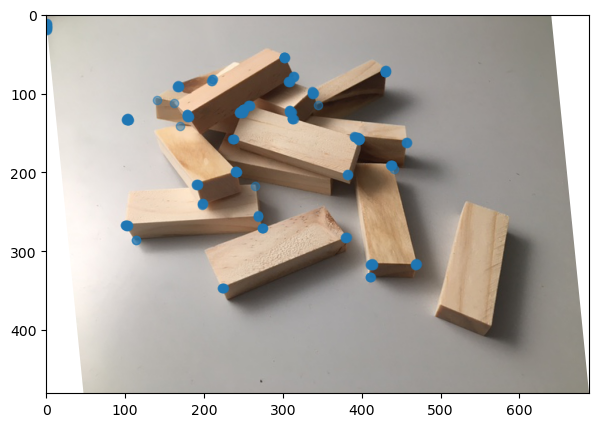

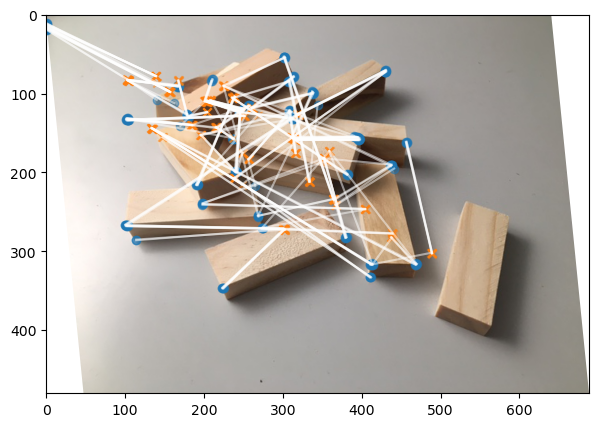

In [6]:
# transformation that is less extreme
XStar = np.array([[1, 0], [0.1, 1]])

# find corners in transformed image
Y = transformImage(imageName, XStar, parametersHarris)

# A, Y may have different number of rows;
# delete excess number of rows of the larger matrix
rMax = min([len(Y), len(A)])
A_c = A[:rMax]
Y_c = Y[:rMax]

plotTransformedImage(imageName, XStar, [], Y_c)

# again, apply the LevSort algorithm
Pihat, Xhat = LevSort(Y_c, A_c)
Yhat = Pihat @ A_c @ Xhat

plotTransformedImage(imageName, XStar, Yhat, Y_c, drawLines=True)

### Example 3: Simulation Study of Example 2 for varying $X^*$

In [7]:
# some error function 
Err = lambda X: np.sum(X**2) / (X.shape[-1] * X.shape[-2])

shear = lambda s: np.array([[1, s], [0, 1]])
scaling = lambda s: np.array([[s, 0], [0, s]])
rotation = lambda alpha: np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])

In [9]:
shears = np.linspace(-3, 3, 40)
alphas = np.linspace(-np.pi, np.pi, 40)

### detect corners in the picture
A = detectCorners(imageName, parametersHarris)

### construct the permutation matrix PiStar
n = len(A)

error = np.zeros((len(alphas), len(shears)))

for i, s in enumerate(shears):
    for j, alpha in enumerate(alphas):
        # build the transformation XStar and transform the original image
        XStar = rotation(alpha) @ shear(s)
        Y, lengthOfTransformedEdge = transformImage(imageName, XStar, parametersHarris, returnLengthTransformedEdge=True)
        
        # cut off remaining rows of the larger of the two
        rMax = min([len(Y), len(A)])
        A_c = A[:rMax]
        Y_c = Y[:rMax]
        
        # again, apply the LevSort algorithm
        Pihat, Xhat = LevSort(Y_c, A_c)
        Yhat = Pihat @ A_c @ Xhat
        
        # compute the error with Err, which has been defined at the top
        # the data is devided by the length of the scaled bottom edge of the image
        error[j, i] = Err((Yhat - Y_c)/lengthOfTransformedEdge)
    
    print(f'Round {i+1}/{len(shears)} done.', end='\r')

/tmp/ipykernel_31312/3334171857.py:34: RuntimeWarning: invalid value encountered in matmul
  lY = np.diag(U_Y @ U_Y.T)
/tmp/ipykernel_31312/3334171857.py:35: RuntimeWarning: invalid value encountered in matmul
  lA = np.diag(U_A @ U_A.T)


In [10]:
scalings = np.logspace(-2, 0, 40)
alphas = np.linspace(-np.pi, np.pi, 40)

error2 = np.zeros((len(alphas), len(scalings)))

for i, s in enumerate(scalings):
    for j, alpha in enumerate(alphas):
        # build the transformation XStar and transform the original image
        XStar = rotation(alpha) @ scaling(s)
        Y, lengthOfTransformedEdge = transformImage(imageName, XStar, parametersHarris, returnLengthTransformedEdge=True)
        
        # cut off remaining rows of the larger of the two
        rMax = min([len(Y), len(A)])
        A_c = A[:rMax]
        Y_c = Y[:rMax]

        # again, apply the LevSort algorithm
        Pihat, Xhat = LevSort(Y_c, A_c)
        Yhat = Pihat @ A_c @ Xhat
        
        # compute the error with Err, which has been defined at the top
        # the data is devided by the length of the scaled bottom edge of the image
        error2[j, i] = Err((Yhat - Y_c)/lengthOfTransformedEdge)
    
    print(f'Round {i+1}/{len(scalings)} done.', end='\r')

/tmp/ipykernel_31312/3334171857.py:34: RuntimeWarning: invalid value encountered in matmul
  lY = np.diag(U_Y @ U_Y.T)
/tmp/ipykernel_31312/3334171857.py:35: RuntimeWarning: invalid value encountered in matmul
  lA = np.diag(U_A @ U_A.T)


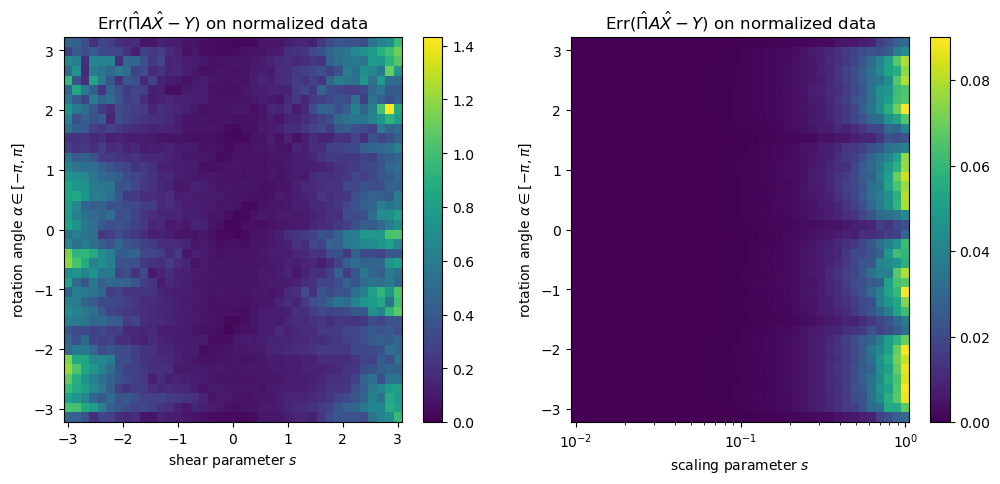

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].set_title(r'Err($\hat{\Pi} A \hat{X} - Y$) on normalized data')
X0, Y0 =  np.meshgrid(shears, alphas)
plot0 = ax[0].pcolormesh(X0, Y0, error, vmin=0)
ax[0].set_xlabel(r'shear parameter $s$')
ax[0].set_ylabel(r'rotation angle $\alpha \in [-\pi, \pi]$')
plt.colorbar(plot0)

ax[1].set_title(r'Err($\hat{\Pi} A \hat{X} - Y$) on normalized data')
X1, Y1 = np.meshgrid(scalings, alphas)
plot1 = ax[1].pcolormesh(X1, Y1, error2, vmin=0)
ax[1].set_xscale('log')
ax[1].set_xlabel(r'scaling parameter $s$')
ax[1].set_ylabel(r'rotation angle $\alpha \in [-\pi, \pi]$')
plt.colorbar(plot1)

### Example 4: Simulation Study of the Asymptotics as $n, m \to \infty$ for arbitrary $d, \Pi, A, X^*, W$

In [18]:
rng = np.random.default_rng(seed=12345)
Err = lambda X: np.sum(X**2) / (X.shape[0] * X.shape[1])
ErrPi = lambda X: np.sum(X**2) / (2* X.shape[0])
epsilon = 1e-11

ds = [2, 50, 100, 900]
ns = np.logspace(1, 3, 20, dtype=int)
ms = np.logspace(1, 3, 20, dtype=int)

# sd = 0.001 already suffices to destroy the behaviour
sig = 0.001 # standard deviation of W_ij


errorsAsymptotics = np.zeros((len(ds), len(ms), len(ns)))
errorsAsymptoticsDenoised = errorsAsymptotics.copy()
errorsAsymptoticsWithW = errorsAsymptotics.copy()
errorsAsymptoticsX = errorsAsymptotics.copy()
errorsAsymptoticsPi = errorsAsymptotics.copy()
removedSomeSigmas = errorsAsymptotics.copy()
conditions = errorsAsymptotics.copy()

counter = 0

for l, d in enumerate(ds):
    for j, m in enumerate(ms):
        for i, n in enumerate(ns):
            
            #W = rng.normal(loc=0, scale=sig, size=(n, m))
            W = np.zeros((n, m))
            A = rng.uniform(low=0, high=1, size=(n, d))
            XStar = rng.uniform(low=0, high=1, size=(d, m))
            PiStar = randomPermutation(rng, n)
            
            Y = PiStar @ A @ XStar + W
            
            # theoretically good choice for lambda
            #lamb = 1.1 * sig * (np.sqrt(n) + np.sqrt(m))
            lamb = 0
            Ydenoised, sigmasRemoved = singularValueThresholding(Y, lamb, returnSigmasRemoved=True)
            
            if sigmasRemoved:
                counter += 1
            Pihat, Xhat, lY, lA = LevSort(Ydenoised, A, returnLevScores=True)
            
            # check if the leverage scores contain entries that are non distinct
            notDestinct = False
            
            for vec in [lA, lY]:
                v_old = 0
                
                if notDestinct:
                    break
                
                for j1, v in enumerate(vec):
                    if j1 > 0 and np.abs(v_old - v) < epsilon:
                        notDestinct = True
                        break
                    
                    v_old = v

                    
            if not notDestinct and np.linalg.matrix_rank(A) <= np.linalg.matrix_rank(XStar):
                conditions[l, j, i] = 1
            
            Yhat = Pihat @ A @ Xhat 
            
            errorsAsymptotics[l, j, i] = Err(PiStar @ A @ XStar - Yhat)
            
            errorsAsymptoticsWithW[l, j, i] = Err(Y - Yhat)
            
            errorsAsymptoticsDenoised[l, j, i] = Err(PiStar @ A @ XStar - Ydenoised)
            
            errorsAsymptoticsX[l, j, i] = Err(Xhat - XStar)
            errorsAsymptoticsPi[l, j, i] =  ErrPi(Pihat - PiStar)
            
            removedSomeSigmas[l, j, i] = sigmasRemoved
            
        print(f'Round {l*len(ms)+j+1}/{len(ds)*len(ms)} done. Removed singular values in {counter/(l*len(ms)+j+1):.2f}% of the SVTs until now.   ', end='\r')

/tmp/ipykernel_31312/3334171857.py:34: RuntimeWarning: invalid value encountered in matmul
  lY = np.diag(U_Y @ U_Y.T)
/tmp/ipykernel_31312/3334171857.py:35: RuntimeWarning: invalid value encountered in matmul
  lA = np.diag(U_A @ U_A.T)


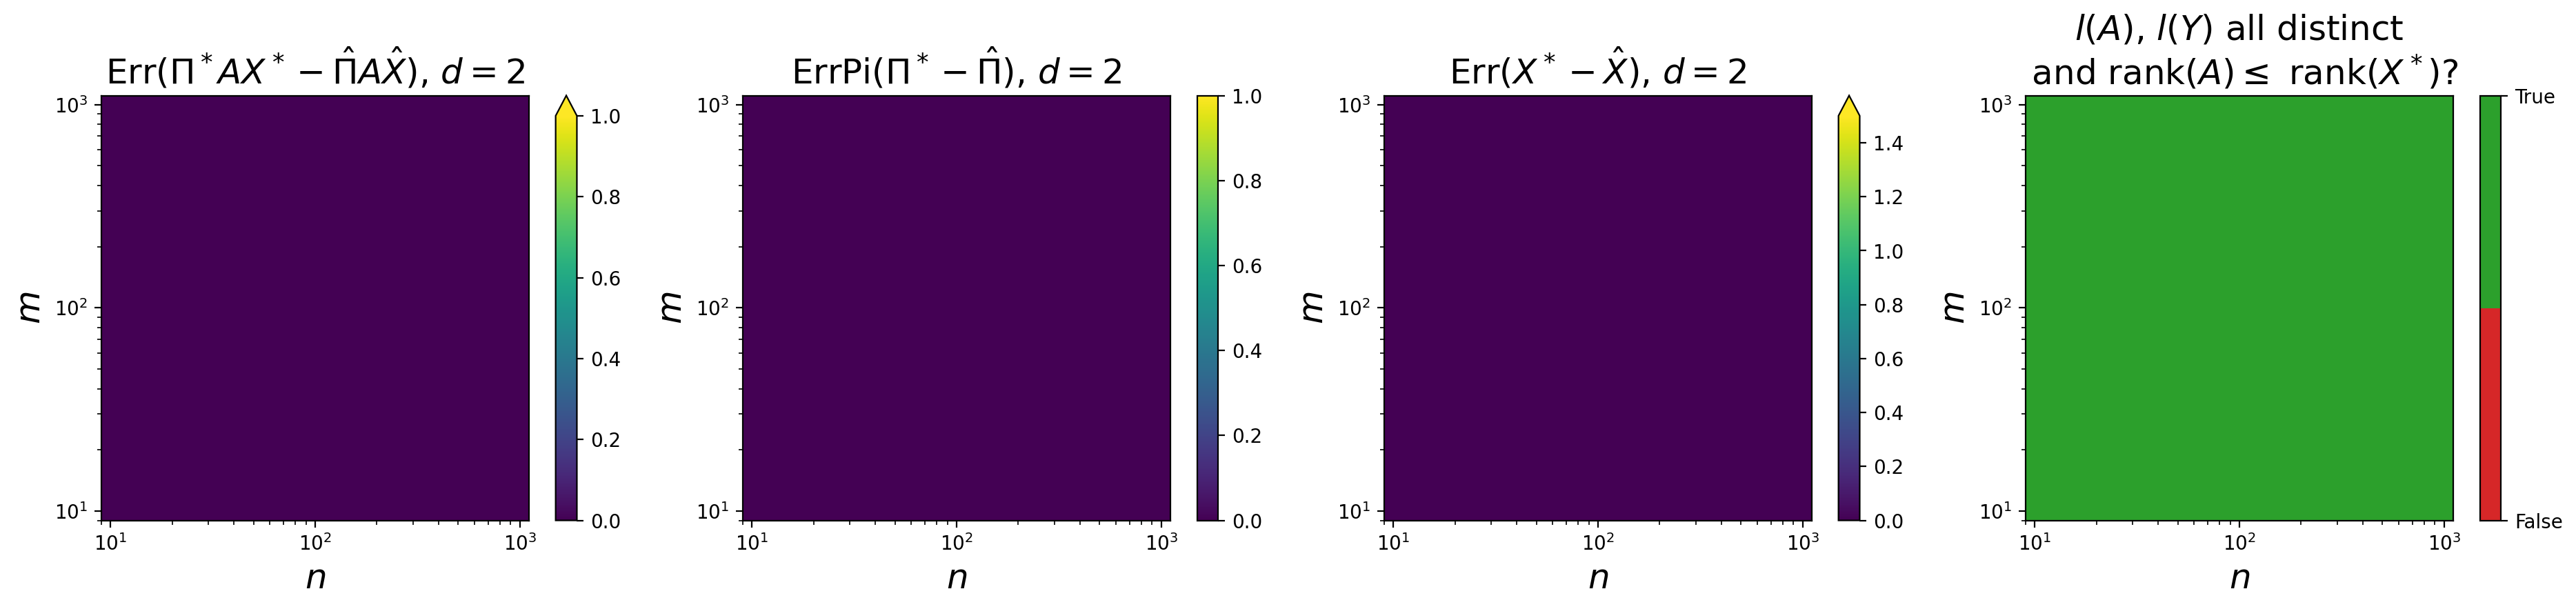

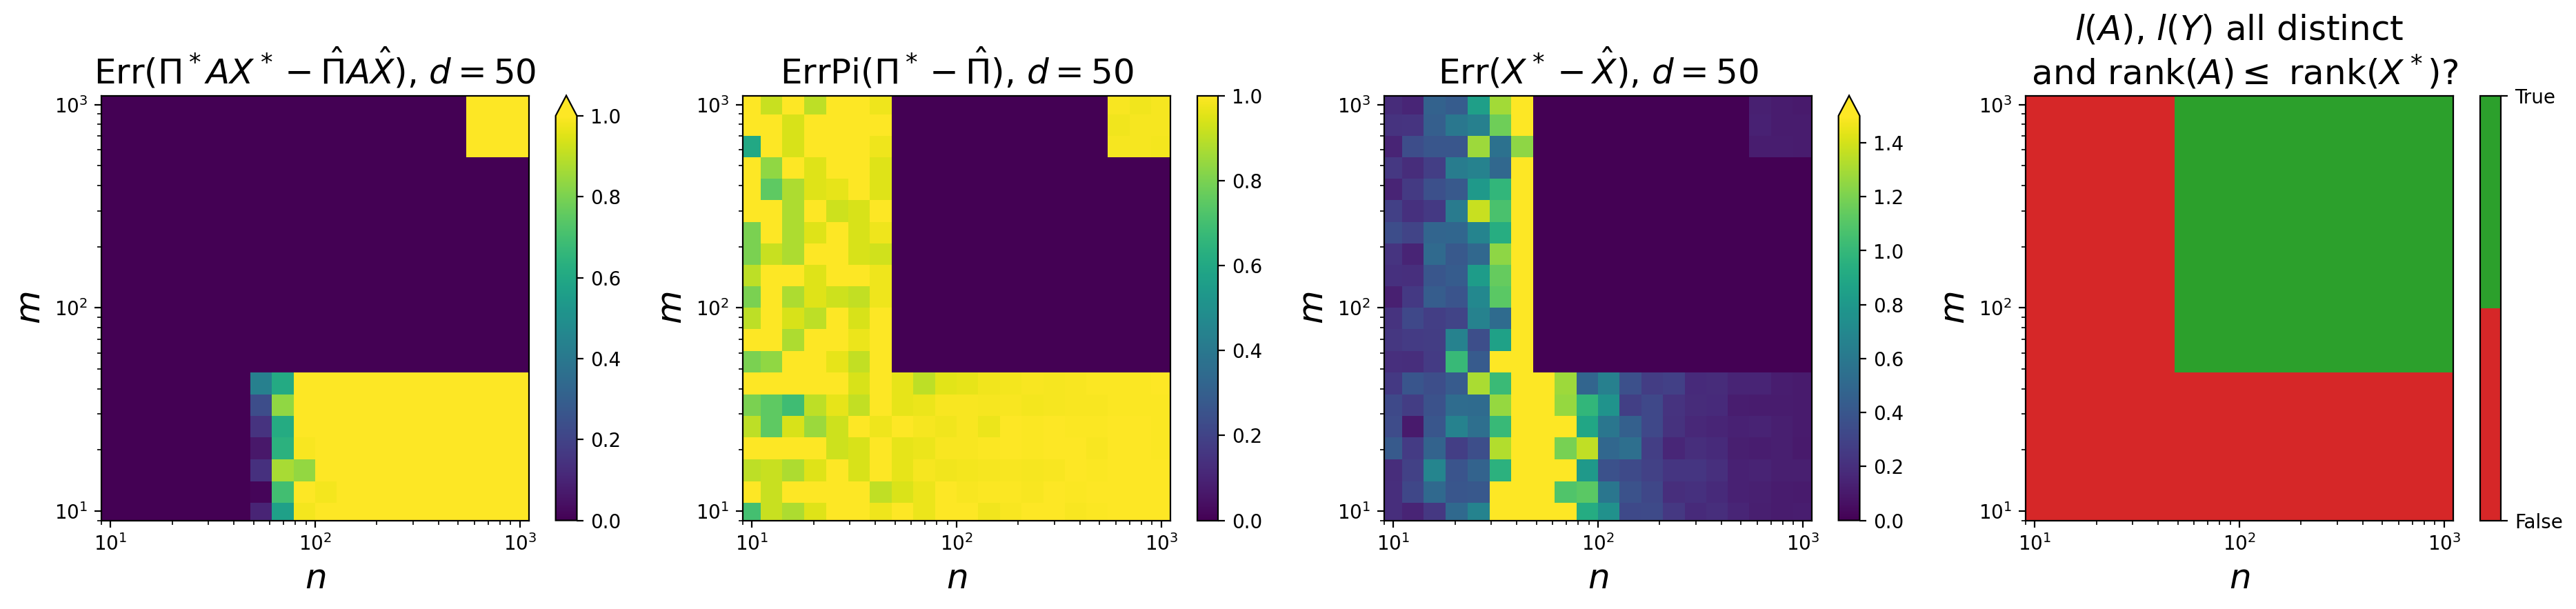

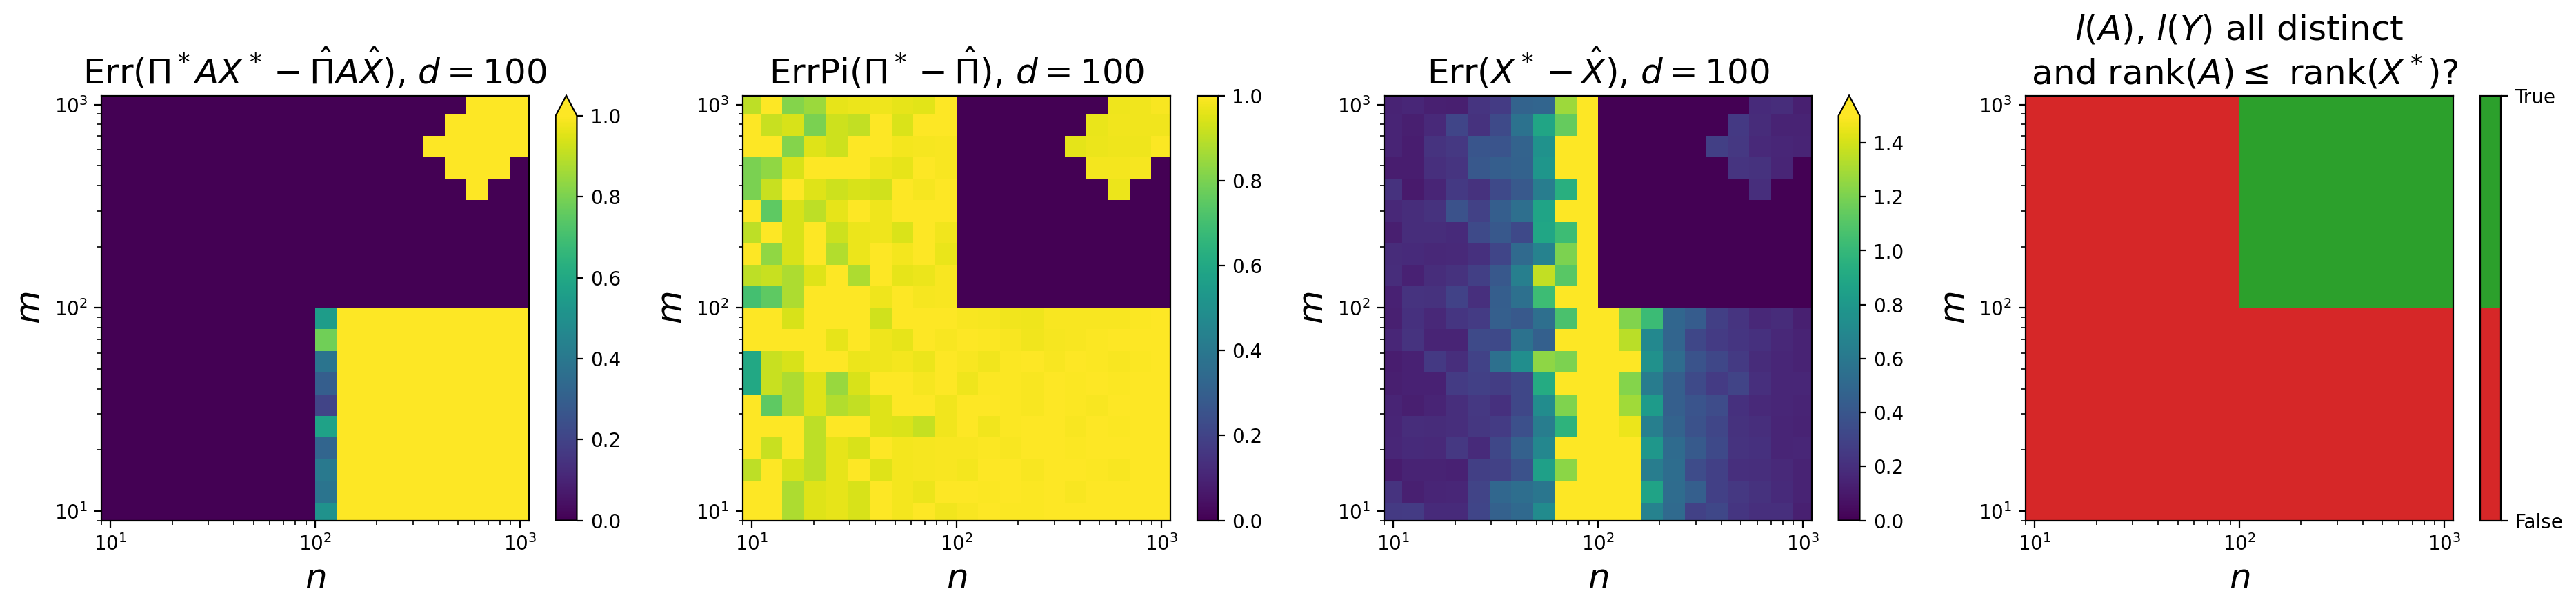

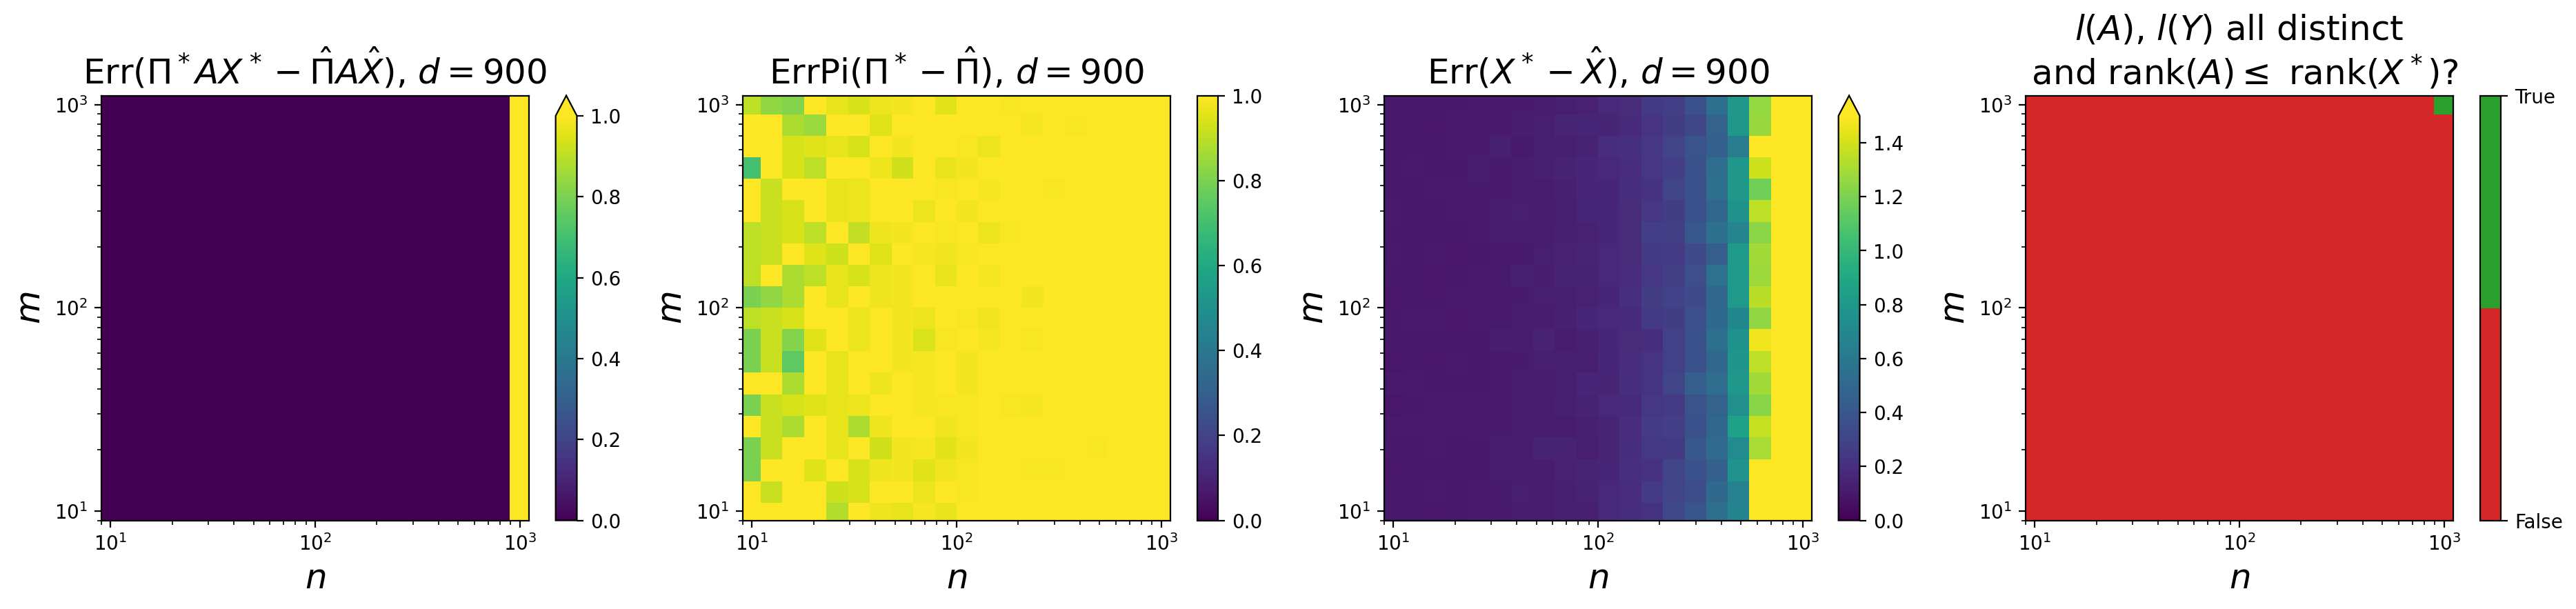

In [19]:
# Summary plot for when W = 0
N, M = np.meshgrid(ns, ms)

for i, d in enumerate(ds):
    fig, ax = plt.subplots(1, 4, figsize=(23, 4), dpi=200)

    ax[0].set_title(r'Err($\Pi^* A X^* - \hat{\Pi} A \hat{X}$), $d = $' + f'{ds[i]}', fontsize = 18)
    plot0 = ax[0].pcolormesh(N, M, errorsAsymptotics[i], vmin=0, vmax=1)
    ax[0].set_xlabel(r'$n$', fontsize = 18)
    ax[0].set_ylabel(r'$m$', fontsize = 18)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    plt.colorbar(plot0, extend='max')
    
    
    ax[1].set_title(r'ErrPi($\Pi^* - \hat{\Pi}$), $d = $' + f'{ds[i]}', fontsize = 18)
    plot1 = ax[1].pcolormesh(N, M, errorsAsymptoticsPi[i], vmin=0, vmax=1)
    ax[1].set_xlabel(r'$n$', fontsize = 18)
    ax[1].set_ylabel(r'$m$', fontsize = 18)
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    plt.colorbar(plot1)
    
    
    ax[2].set_title(r'Err($X^* - \hat{X}$), $d = $' + f'{ds[i]}', fontsize = 18)
    plot2 = ax[2].pcolormesh(N, M, errorsAsymptoticsX[i], vmin=0, vmax=1.5)
    ax[2].set_xlabel(r'$n$', fontsize = 18)
    ax[2].set_ylabel(r'$m$', fontsize = 18)
    ax[2].set_xscale('log')
    ax[2].set_yscale('log')
    plt.colorbar(plot2, extend='max')
    
    
    colors = ["tab:red", "tab:green"]
    my_cmap = mcolor.ListedColormap(colors, name="my_cmap")
    
    ax[3].set_title('$l(A)$, $l(Y)$' + ' all distinct\n and rank$(A) \leq $ rank$(X^*)$?', fontsize = 18)
    plot3 = ax[3].pcolormesh(N, M, conditions[i], cmap=my_cmap, vmin=0, vmax=1)
    ax[3].set_xlabel(r'$n$', fontsize = 18)
    ax[3].set_ylabel(r'$m$', fontsize = 18)
    ax[3].set_xscale('log')
    ax[3].set_yscale('log')
    plt.colorbar(plot3, ticks=[0, 1], format=mticker.FixedFormatter(['False', 'True']),)

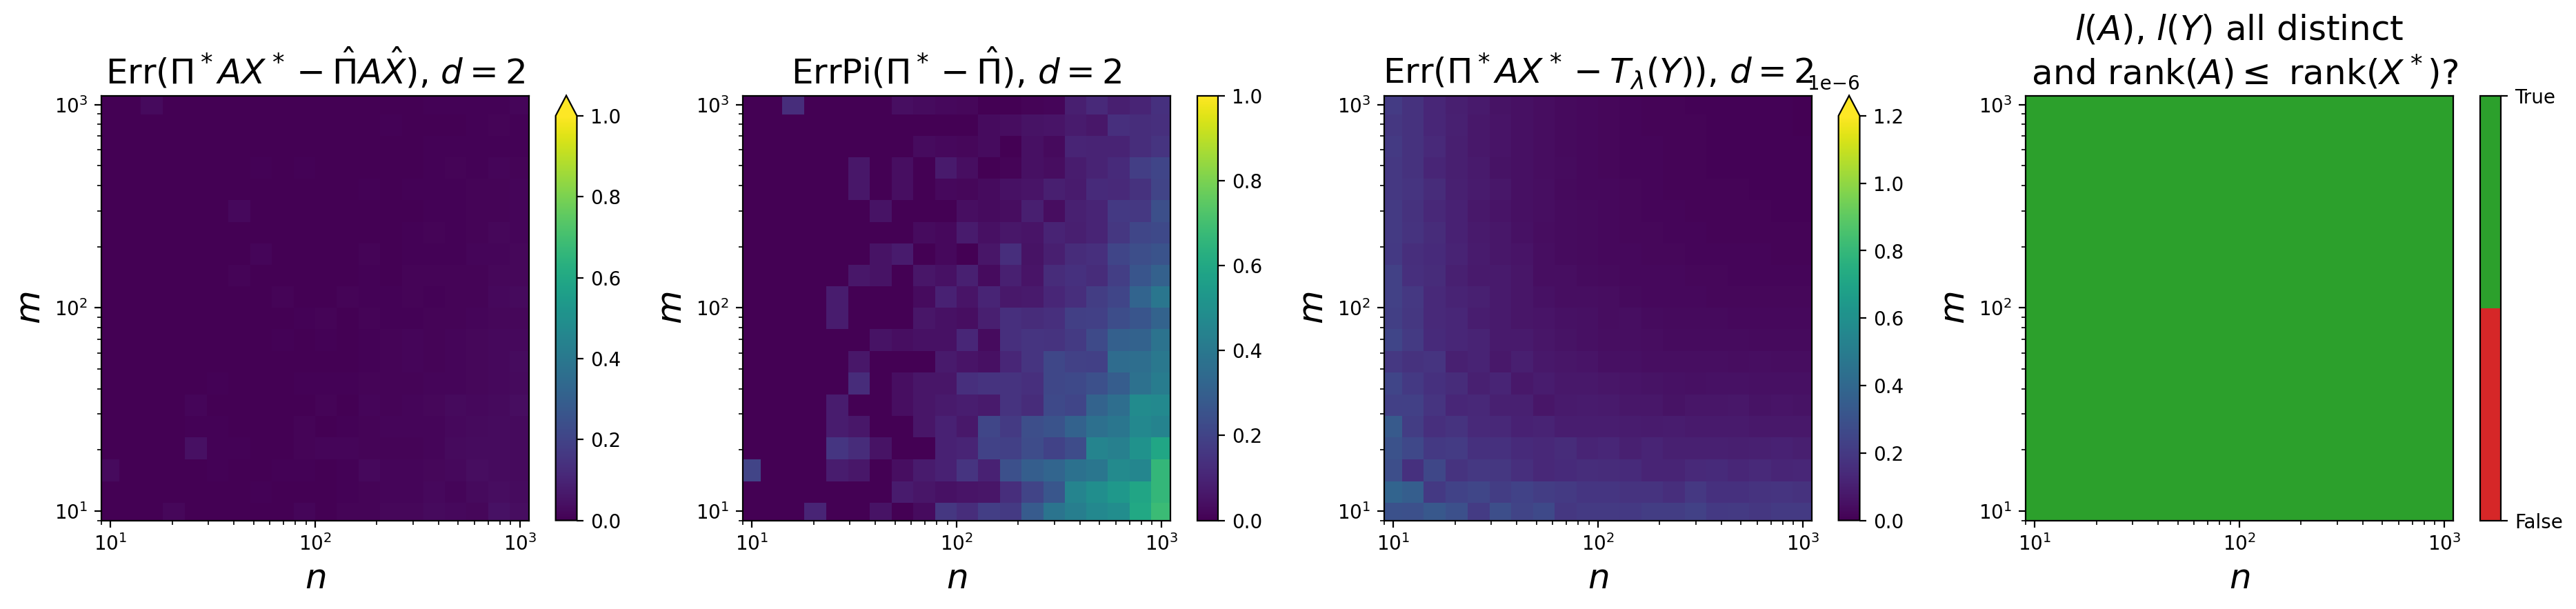

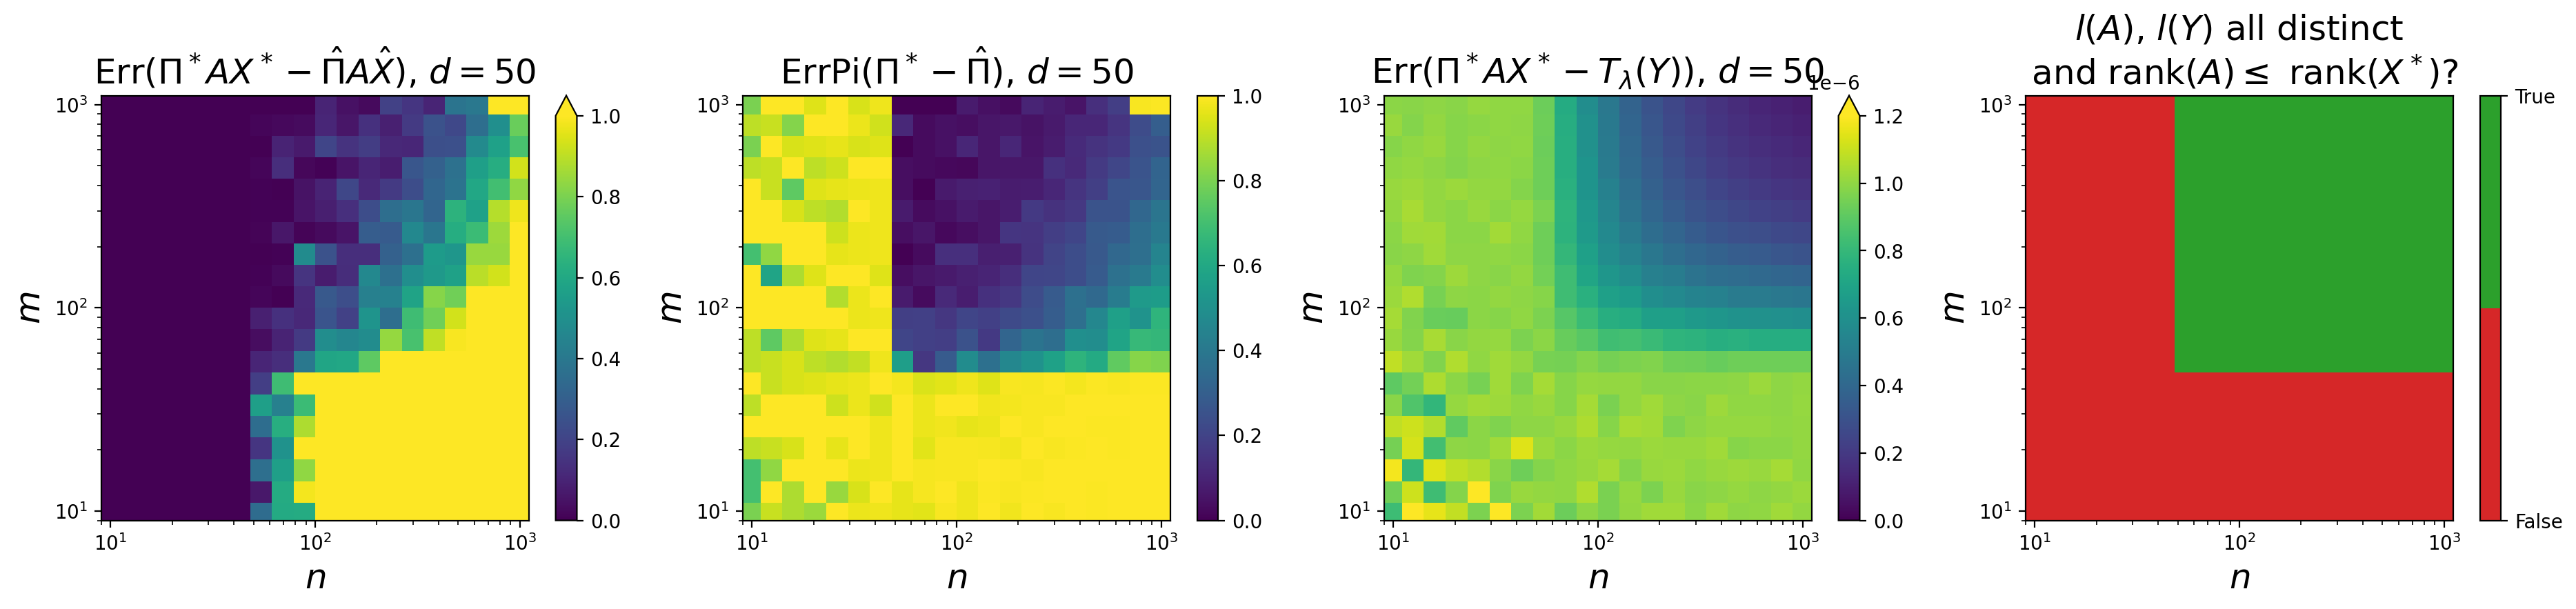

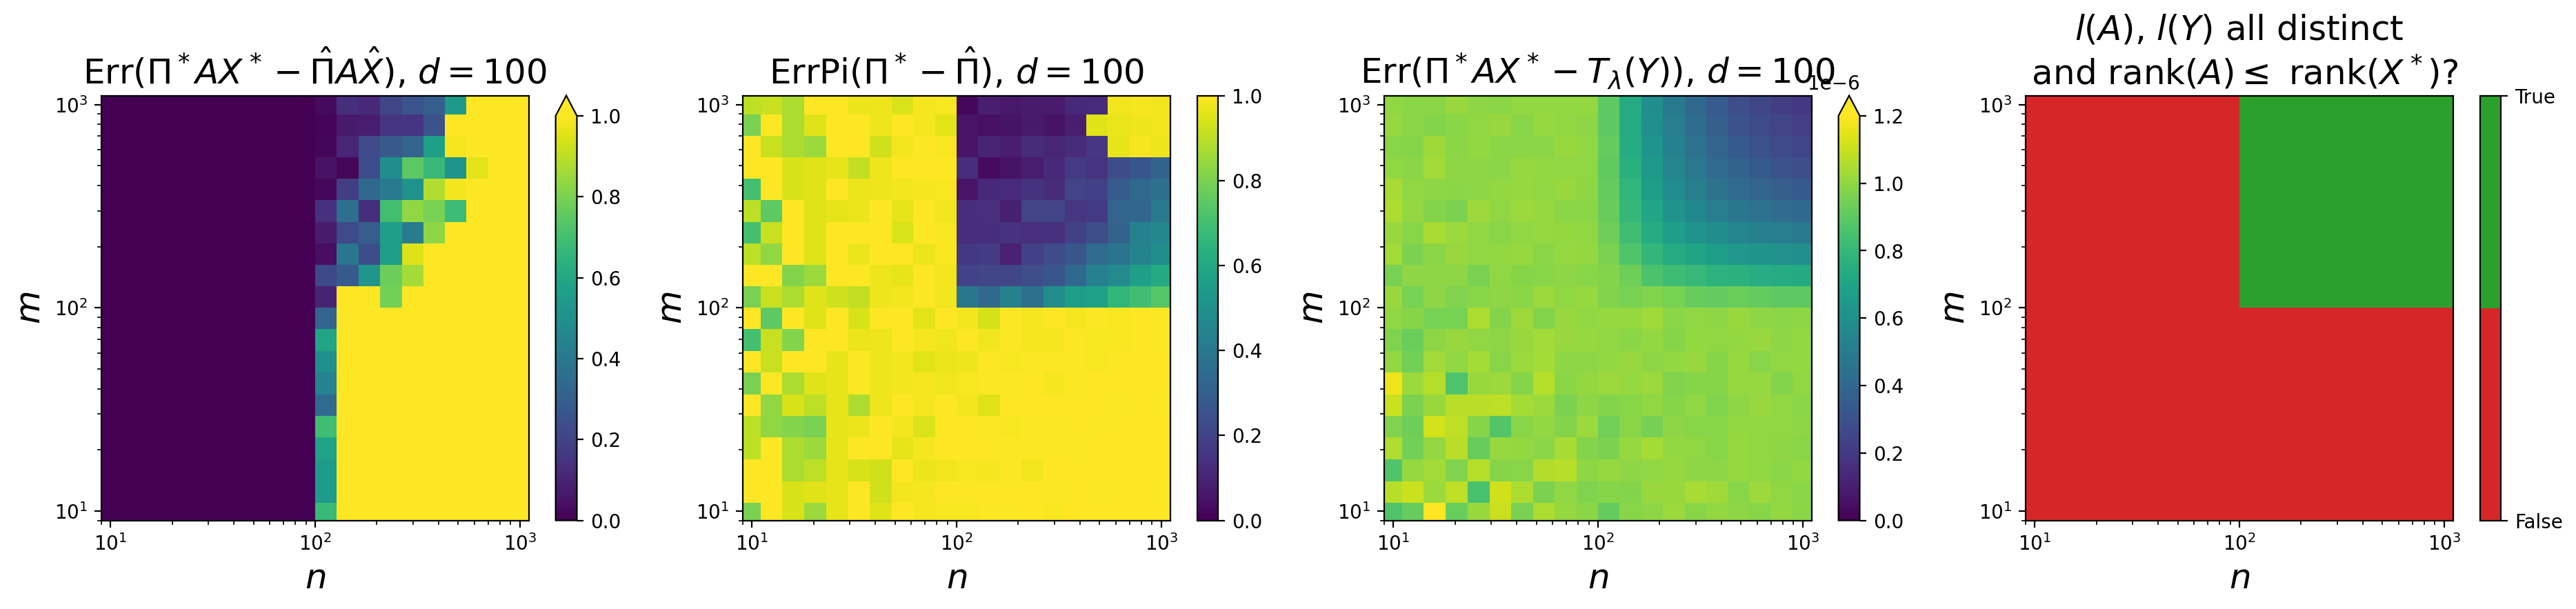

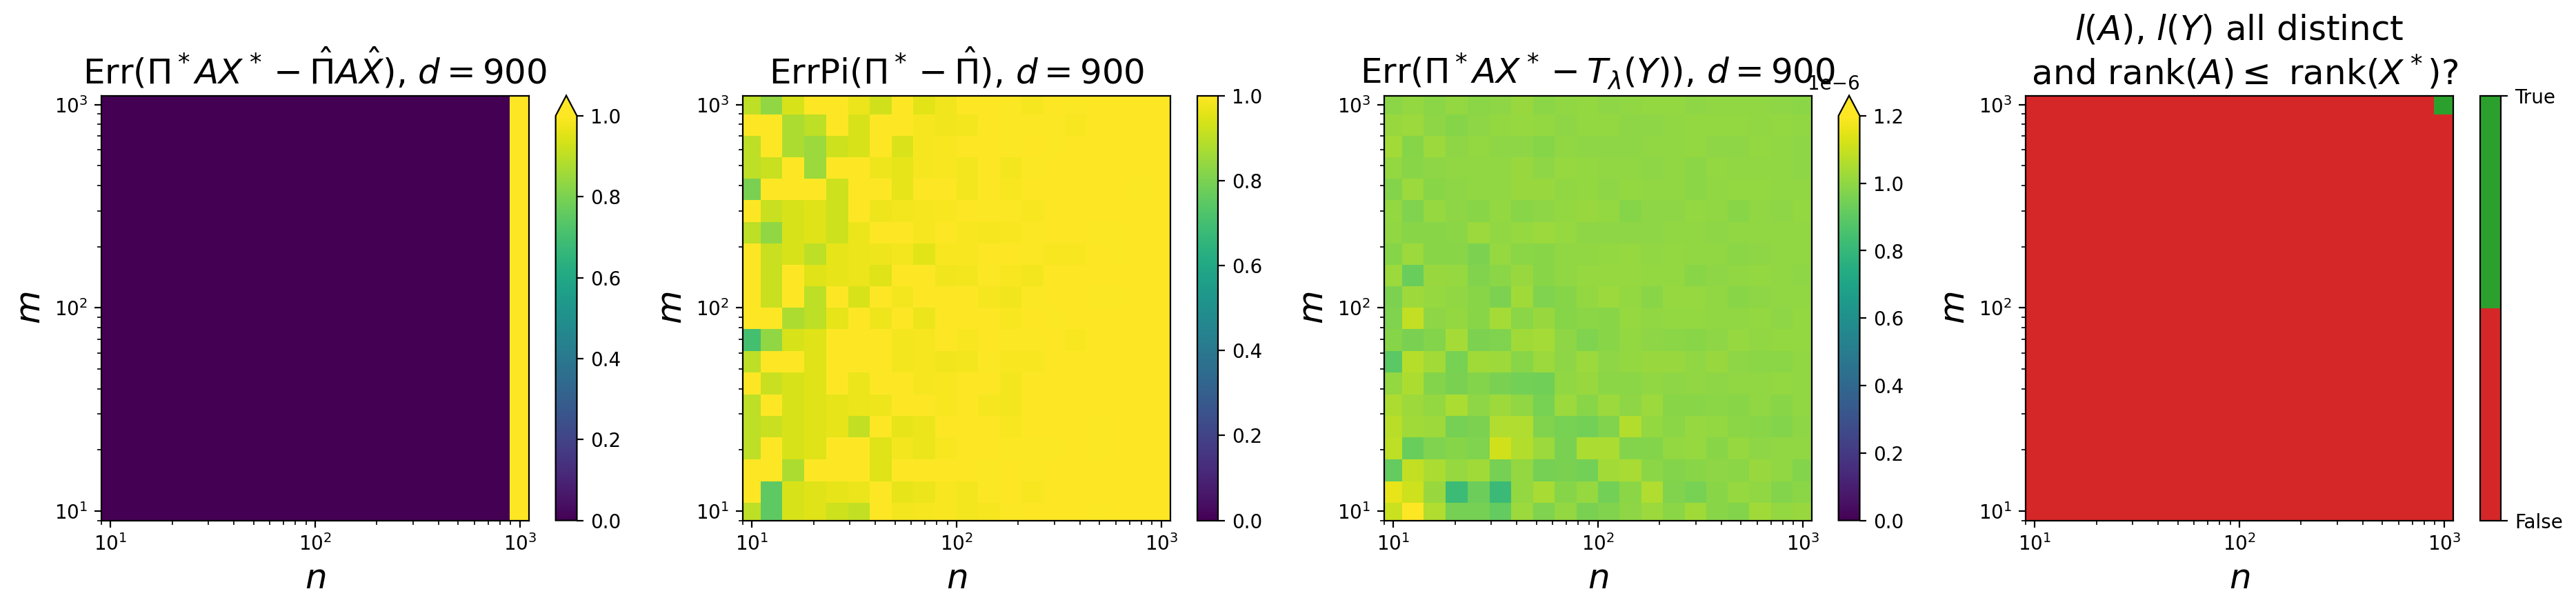

In [17]:
# Summary plot for when W is not equal to the all zeros matrix and there is some SVT going on

N, M = np.meshgrid(ns, ms)

for i, d in enumerate(ds):
    fig, ax = plt.subplots(1, 4, figsize=(23, 4), dpi=200)

    ax[0].set_title(r'Err($\Pi^* A X^* - \hat{\Pi} A \hat{X}$), $d = $' + f'{ds[i]}', fontsize = 18)
    plot0 = ax[0].pcolormesh(N, M, errorsAsymptotics[i], vmin=0, vmax=1)
    ax[0].set_xlabel(r'$n$', fontsize = 18)
    ax[0].set_ylabel(r'$m$', fontsize = 18)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    plt.colorbar(plot0, extend='max')
    
    
    ax[1].set_title(r'ErrPi($\Pi^* - \hat{\Pi}$), $d = $' + f'{ds[i]}', fontsize = 18)
    plot1 = ax[1].pcolormesh(N, M, errorsAsymptoticsPi[i], vmin=0, vmax=1)
    ax[1].set_xlabel(r'$n$', fontsize = 18)
    ax[1].set_ylabel(r'$m$', fontsize = 18)
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    plt.colorbar(plot1)
    
    
    ax[2].set_title(r'Err($\Pi^* A X^* - T_\lambda(Y)$), $d = $' + f'{ds[i]}', fontsize = 18)
    plot2 = ax[2].pcolormesh(N, M, errorsAsymptoticsDenoised[i], vmin=0, vmax=1.2e-6)
    ax[2].set_xlabel(r'$n$', fontsize = 18)
    ax[2].set_ylabel(r'$m$', fontsize = 18)
    ax[2].set_xscale('log')
    ax[2].set_yscale('log')
    plt.colorbar(plot2, extend='max')
    
    
    colors = ["tab:red", "tab:green"]
    my_cmap = mcolor.ListedColormap(colors, name="my_cmap")
    
    ax[3].set_title('$l(A)$, $l(Y)$' + ' all distinct\n and rank$(A) \leq $ rank$(X^*)$?', fontsize = 18)
    plot3 = ax[3].pcolormesh(N, M, conditions[i], cmap=my_cmap, vmin=0, vmax=1)
    ax[3].set_xlabel(r'$n$', fontsize = 18)
    ax[3].set_ylabel(r'$m$', fontsize = 18)
    ax[3].set_xscale('log')
    ax[3].set_yscale('log')
    plt.colorbar(plot3, ticks=[0, 1], format=mticker.FixedFormatter(['False', 'True']),)
    
    